<a href="https://colab.research.google.com/github/abhi15-bose-max/Generativereplaymodel/blob/main/GenerativeReplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🧠 Split MNIST - Generative Replay vs No Replay (Colab-Ready)

# Install dependencies
!pip install torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00


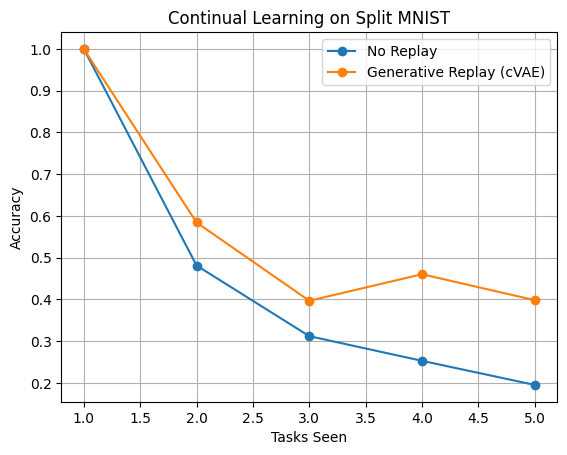

In [ ]:
# 🧠 Continual Learning with cVAE on Split MNIST


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# CONFIG
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
num_epochs = 5
num_tasks = 5

# -------------------------------
# DATA LOADER: SPLIT MNIST
# -------------------------------
transform = transforms.ToTensor()
mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

def get_task_dataset(task_id):
    class_ids = [2 * task_id, 2 * task_id + 1]
    indices = [i for i, (x, y) in enumerate(mnist) if y in class_ids]
    subset = Subset(mnist, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=True), class_ids

# -------------------------------
# Simple Classifier
# -------------------------------
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# -------------------------------
# Class-Conditional VAE
# -------------------------------
class ConditionalVAE(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.fc1 = nn.Linear(784 + num_classes, 256)
        self.fc21 = nn.Linear(256, 20)
        self.fc22 = nn.Linear(256, 20)
        self.fc3 = nn.Linear(20 + num_classes, 256)
        self.fc4 = nn.Linear(256, 784)

    def encode(self, x, y):
        x = x.view(-1, 784)
        y_onehot = F.one_hot(y, self.num_classes).float()
        inputs = torch.cat([x, y_onehot], dim=1)
        h1 = F.relu(self.fc1(inputs))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_onehot = F.one_hot(y, self.num_classes).float()
        z_cond = torch.cat([z, y_onehot], dim=1)
        h3 = F.relu(self.fc3(z_cond))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# -------------------------------
# MODEL INITIALIZATION
# -------------------------------
classifier_no_replay = Classifier().to(device)
classifier_with_replay = Classifier().to(device)
generator = ConditionalVAE().to(device)

optimizer_clf = torch.optim.Adam(classifier_no_replay.parameters(), lr=1e-3)
optimizer_clf_replay = torch.optim.Adam(classifier_with_replay.parameters(), lr=1e-3)
optimizer_vae = torch.optim.Adam(generator.parameters(), lr=1e-3)

acc_no_replay = []
acc_with_replay = []

# -------------------------------
# TRAINING LOOP
# -------------------------------
for task_id in range(num_tasks):
    dataloader, classes = get_task_dataset(task_id)

    # -- Train VAE on current task
    generator.train()
    for epoch in range(2):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer_vae.zero_grad()
            recon, mu, logvar = generator(x, y)
            loss = vae_loss(recon, x, mu, logvar)
            loss.backward()
            optimizer_vae.step()

    # -- Train classifier without replay
    classifier_no_replay.train()
    for epoch in range(num_epochs):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer_clf.zero_grad()
            out = classifier_no_replay(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer_clf.step()

    # -- Train classifier with generative replay
    classifier_with_replay.train()
    for epoch in range(num_epochs):
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer_clf_replay.zero_grad()

            # Real data
            output_real = classifier_with_replay(x)
            loss_real = F.cross_entropy(output_real, y)

            # Generate fake data
            y_gen = torch.randint(0, 10, (x.size(0),)).to(device)
            z = torch.randn(x.size(0), 20).to(device)
            x_gen = generator.decode(z, y_gen).detach()
            output_fake = classifier_with_replay(x_gen.view(-1, 1, 28, 28))
            loss_fake = F.cross_entropy(output_fake, y_gen)

            loss = loss_real + 0.5 * loss_fake
            loss.backward()
            optimizer_clf_replay.step()

    # -- Evaluation on all seen tasks
    def evaluate(model):
        model.eval()
        correct = 0
        total = 0
        for t in range(task_id + 1):
            test_loader, _ = get_task_dataset(t)
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                with torch.no_grad():
                    out = model(x)
                    pred = out.argmax(dim=1)
                    correct += (pred == y).sum().item()
                    total += y.size(0)
        return correct / total

    acc_no_replay.append(evaluate(classifier_no_replay))
    acc_with_replay.append(evaluate(classifier_with_replay))

# -------------------------------
# PLOT RESULTS
# -------------------------------
plt.plot(range(1, num_tasks + 1), acc_no_replay, label="No Replay", marker='o')
plt.plot(range(1, num_tasks + 1), acc_with_replay, label="Generative Replay (cVAE)", marker='o')
plt.title("Continual Learning on Split MNIST")
plt.xlabel("Tasks Seen")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()
